In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 5) Multivariate with Rosemblat and couplas

Model:

$ u = I\,e^{-a\,x} $ 

In [2]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)

In [3]:
dist_a = cp.Normal(.8,.2)#cp.Uniform(.6,.8)
dist_I = cp.Weibull(shape=2., scale=2., shift=0) + 4.
dist = cp.J(dist_a, dist_I)
#dist_Q = cp.Clayton(dist, theta=2.)
#dist_Q = cp.Copula(dist, cp.gumbel(len(dist), theta=2.) ) ## dist_Q = cp.Gumbel(dist, theta=2.) ## Does not work
dist_Q = cp.Joe(dist, theta=5.)
dist_R = cp.J(cp.Uniform(),cp.Uniform())

### a) Full MC with Halton sampling

In [4]:
sample_inputs = dist_Q.sample(size=1000,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

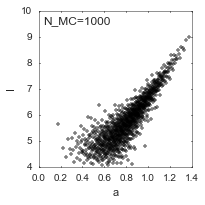

In [5]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.05,9.5,'N_MC='+str(len(sample_inputs[0,:])))

fig.tight_layout()
#fig.savefig('Figures/5_Joe_copula_MC_sample.pdf')
print

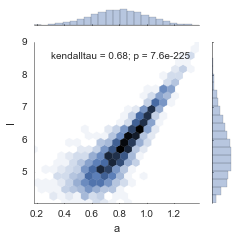

In [6]:
fig=sns.jointplot(sample_inputs[0,:],
              sample_inputs[1,:], 
              kind="hex", 
              stat_func=stats.kendalltau,
              size=3.5
             )

fig.set_axis_labels('a','I')
fig = plt.gcf()
fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_MC_sample_joint.pdf')
print

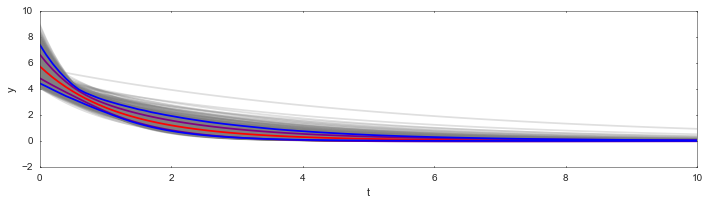

In [7]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_MC.pdf')
print

### b) Point collocation: Least squares

In [8]:
M = 5     # Order of the polynomial
N = M + 1 # Number of terms

In [9]:
P = cp.orth_ttr(M,dist_R)
# Exponenial rule
nodes_R = dist_R.sample(2**M-1,rule='M') #
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = [u(x,*node) for node in nodes_Q.T]

In [30]:
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc,
                          #rule='LS') 
                          #rule='T',alpha=1e-2) 
                          rule='LL', alpha=1e-9, max_iter=300) 

31


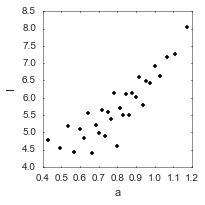

In [31]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.k')

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_PCE_sample.pdf')
print len(nodes_Q[0,:])

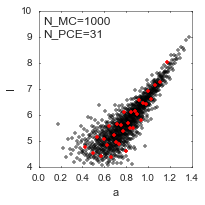

In [32]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.05,9.5,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.05,9,'N_PCE='+str(len(nodes_Q[0,:])))

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_MC_sample.pdf')
print

 q0, q1
[1436, 1402]

(101, 21)
(1, 0) -0.578257104867
(2, 0) 2.61663895188
(4, 0) 5.15505109145
(5, 0) -1.78081176909
(0, 1) -0.00779223348724
(1, 2) -0.120869202578
(3, 2) 1.01556566347
(0, 0) 0.0567229318771
(3, 0) -5.47146710083
(1, 1) -0.651596998681
(2, 1) 1.74967209068
(3, 1) -1.04171972948
(4, 1) 0.0
(0, 2) 0.468833424301
(2, 2) -1.70057722136
(1, 3) 1.48167826396
(2, 3) 0.0
(0, 3) -0.914557539804
(1, 4) -0.740839131982
(0, 4) 0.461990664623
(0, 5) 0.0


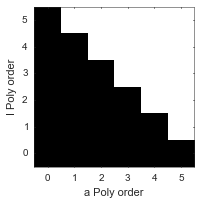

In [33]:
print ' q0, q1'
print [str(u_hat).count(q) for q in ['q0','q1']]
print 
print u_hat.coeffs().shape
for i in range(len(u_hat.expons())):
    print u_hat.expons()[i], u_hat.coeffs()[100,i]
    
A=np.zeros([M+1,M+1])
for i in range(len(u_hat.expons())):
    if any(u_hat.coeffs()[i] != 0):
        A[u_hat.expons()[i]]=1.#u_hat.coeffs()[i]
    
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.imshow(A[:,:], interpolation='nearest',origin='lower')
ax.set_xlabel('a Poly order')
ax.set_ylabel('I Poly order')
fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_PCE_sparse.pdf')

In [34]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

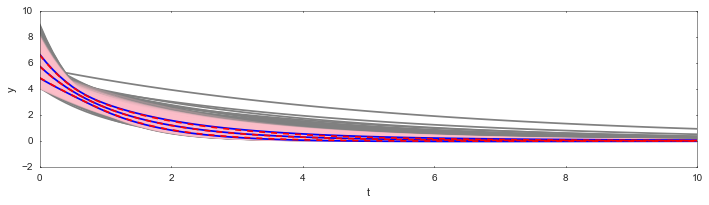

In [35]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

#ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_top.pdf')
print

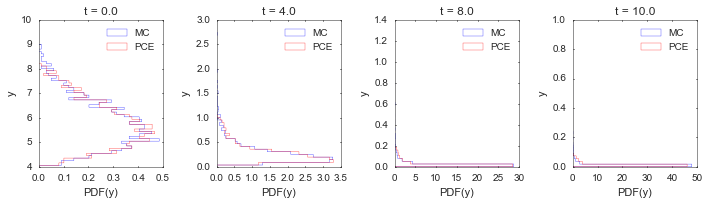

In [36]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    _, bins , _ = ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=bins,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_bot.pdf')
print

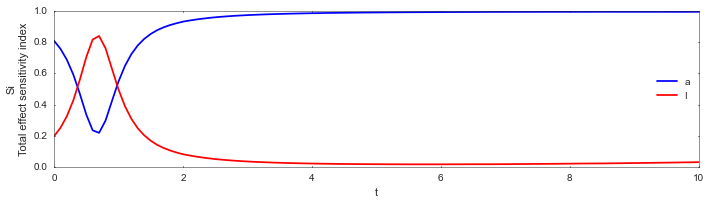

In [37]:
Sensitivity = cp.Sens_t(u_hat, dist_R)

fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_Sens.pdf')